# 💪 FitMatch — Workout Plan Recommender System

---

## Step 1: Problem Definition

**Domain:** Fitness / Workout Recommendation

**What is being recommended?**  
Workout plans (e.g., "Morning Run Blast", "Full Body Strength") to users based on their fitness profile and past preferences.

**Who are the users?**  
Fitness enthusiasts with varying ages (18–59), fitness levels (beginner/intermediate/advanced), and goals (weight loss, muscle gain, endurance, flexibility).

**Objective:**  
Top-N recommendation (Top-5) — for each user, suggest 5 workout plans they are most likely to enjoy.

**Algorithms:**
1. **Most Popular** (Baseline) — Recommend plans with highest average rating
2. **User-Based Collaborative Filtering** (Primary) — Cosine similarity on user-item rating matrix
3. **Content-Based Filtering** (Bonus) — TF-IDF on plan descriptions + cosine similarity
4. **Hybrid** (Bonus) — Weighted blend of CF + Content-Based

**Justification:**  
User-Based CF is ideal for this domain because users with similar fitness profiles tend to enjoy similar workouts. The content-based approach adds value by capturing workout attribute similarity, and the hybrid model combines the strengths of both.

---
## Step 2: Data Preparation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from generate_dataset import generate_users, generate_workout_plans, generate_ratings
from recommender import (
    MostPopularRecommender,
    UserBasedCFRecommender,
    ContentBasedRecommender,
    HybridRecommender,
    split_train_test,
    evaluate_model,
    precision_at_k,
    recall_at_k
)

print('All modules imported successfully!')

All modules imported successfully!


In [2]:
# Generate the dataset
np.random.seed(42)

users = generate_users(n=100)
plans = generate_workout_plans(n=60)
ratings = generate_ratings(users, plans)

print(f'Users:    {len(users)}')
print(f'Plans:    {len(plans)}')
print(f'Ratings:  {len(ratings)}')

# Sparsity
total_possible = len(users) * len(plans)
sparsity = 1 - len(ratings) / total_possible
print(f'\nTotal possible interactions: {total_possible}')
print(f'Dataset Sparsity: {sparsity:.2%}')

Users:    100
Plans:    60
Ratings:  970

Total possible interactions: 6000
Dataset Sparsity: 83.83%


In [3]:
# Explore user attributes
print('=== User Demographics ===')
print(f'\nAge range: {users["age"].min()} – {users["age"].max()}')
print(f'Mean age: {users["age"].mean():.1f}')
print(f'\nFitness Level Distribution:')
print(users['fitness_level'].value_counts())
print(f'\nGoal Distribution:')
print(users['goal'].value_counts())

users.head(10)

=== User Demographics ===

Age range: 18 – 59
Mean age: 37.9

Fitness Level Distribution:
fitness_level
beginner        43
intermediate    39
advanced        18
Name: count, dtype: int64

Goal Distribution:
goal
muscle_gain    33
weight_loss    29
endurance      19
flexibility    19
Name: count, dtype: int64


,user_id,age,fitness_level,goal
0,1,56,advanced,endurance
1,2,46,intermediate,weight_loss
2,3,32,beginner,muscle_gain
3,4,25,beginner,endurance
4,5,38,intermediate,weight_loss
5,6,56,intermediate,weight_loss
6,7,36,intermediate,flexibility
7,8,40,beginner,muscle_gain
8,9,28,intermediate,weight_loss
9,10,28,beginner,flexibility


In [4]:
# Explore workout plans
print('=== Workout Plans ===')
print(f'\nPlan Types:')
print(plans['type'].value_counts())
print(f'\nDifficulty Distribution:')
print(plans['difficulty'].value_counts())
print(f'\nTarget Goals:')
print(plans['target_goal'].value_counts())
print(f'\nDuration range: {plans["duration_min"].min()} – {plans["duration_min"].max()} minutes')

plans[['plan_id', 'name', 'type', 'difficulty', 'duration_min', 'target_goal']].head(10)

=== Workout Plans ===

Plan Types:
type
cardio            10
strength          10
yoga              10
HIIT              10
cross_training    10
pilates            5
stretching         5
Name: count, dtype: int64

Difficulty Distribution:
difficulty
intermediate    23
beginner        21
advanced        16
Name: count, dtype: int64

Target Goals:
target_goal
flexibility    19
muscle_gain    15
weight_loss    14
endurance      12
Name: count, dtype: int64

Duration range: 15 – 75 minutes


,plan_id,name,type,difficulty,duration_min,target_goal
0,1,Morning Run Blast,cardio,beginner,30,weight_loss
1,2,Sprint Interval Training,cardio,advanced,25,endurance
2,3,Fat Burn Cycling,cardio,intermediate,40,weight_loss
3,4,Jump Rope Cardio,cardio,intermediate,20,weight_loss
4,5,Stairclimber Endurance,cardio,beginner,35,endurance
5,6,Dance Cardio Party,cardio,beginner,45,weight_loss
6,7,Rowing Power Session,cardio,advanced,30,endurance
7,8,Trail Run Adventure,cardio,intermediate,50,endurance
8,9,Elliptical Fat Burner,cardio,beginner,35,weight_loss
9,10,Cardio Boxing Blast,cardio,intermediate,30,weight_loss


In [5]:
# Explore ratings
print('=== Ratings ===')
print(f'\nRating Distribution:')
print(ratings['rating'].value_counts().sort_index())
print(f'\nMean rating: {ratings["rating"].mean():.2f}')
print(f'Ratings per user  — min: {ratings.groupby("user_id").size().min()}, '
      f'max: {ratings.groupby("user_id").size().max()}, '
      f'mean: {ratings.groupby("user_id").size().mean():.1f}')
print(f'Ratings per plan  — min: {ratings.groupby("plan_id").size().min()}, '
      f'max: {ratings.groupby("plan_id").size().max()}, '
      f'mean: {ratings.groupby("plan_id").size().mean():.1f}')

ratings.head(10)

=== Ratings ===

Rating Distribution:
rating
1     24
2    142
3    341
4    330
5    133
Name: count, dtype: int64

Mean rating: 3.42
Ratings per user  — min: 5, max: 15, mean: 9.7
Ratings per plan  — min: 8, max: 27, mean: 16.2


,user_id,plan_id,rating
0,1,21,2
1,1,24,2
2,1,5,3
3,1,38,5
4,1,2,5
5,1,32,3
6,1,36,4
7,2,29,3
8,2,51,4
9,2,9,4


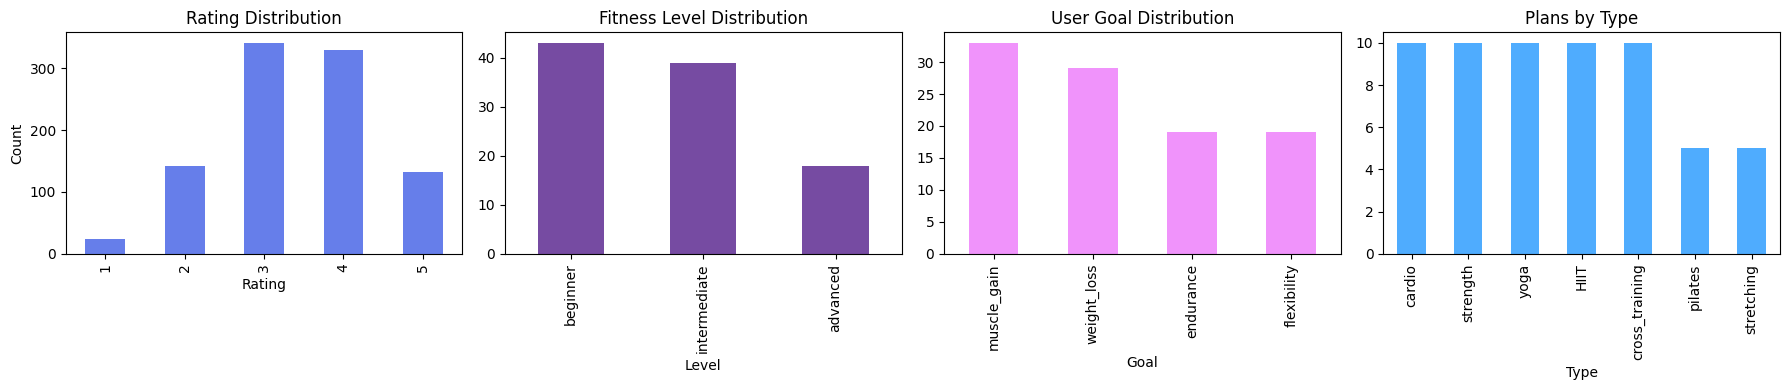

In [7]:
# Visualize distributions
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Rating distribution
ratings['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='#667eea')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Fitness level
users['fitness_level'].value_counts().plot(kind='bar', ax=axes[1], color='#764ba2')
axes[1].set_title('Fitness Level Distribution')
axes[1].set_xlabel('Level')

# Goal distribution
users['goal'].value_counts().plot(kind='bar', ax=axes[2], color='#f093fb')
axes[2].set_title('User Goal Distribution')
axes[2].set_xlabel('Goal')

# Plans per type
plans['type'].value_counts().plot(kind='bar', ax=axes[3], color='#4facfe')
axes[3].set_title('Plans by Type')
axes[3].set_xlabel('Type')

plt.tight_layout()
plt.show()

In [8]:
# Train/Test Split (80/20)
train, test = split_train_test(ratings, test_size=0.2, seed=42)

print(f'Train set: {len(train)} ratings')
print(f'Test set:  {len(test)} ratings')
print(f'Ratio:     {len(train)/len(ratings):.0%} / {len(test)/len(ratings):.0%}')
print(f'\nUsers in train: {train["user_id"].nunique()}')
print(f'Users in test:  {test["user_id"].nunique()}')

Train set: 815 ratings
Test set:  155 ratings
Ratio:     84% / 16%

Users in train: 100
Users in test:  100


---
## Step 3: Model Development

In [9]:
# 1. Most Popular Recommender (Baseline)
pop_model = MostPopularRecommender()
pop_model.fit(train)

print('=== Most Popular Baseline ===')
print('Top 10 most popular workout plans:')
top_popular = pop_model.popular_plans.head(10).merge(
    plans[['plan_id', 'name', 'type']], on='plan_id'
)
top_popular[['plan_id', 'name', 'type', 'mean', 'count']]

=== Most Popular Baseline ===
Top 10 most popular workout plans:


,plan_id,name,type,mean,count
0,53,Boot Camp Blast,cross_training,4.166667,12
1,30,Yoga Sculpt,yoga,4.062500,16
2,11,Full Body Strength,strength,4.000000,15
3,17,Kettlebell Strength Flow,strength,4.000000,7
4,45,Pilates Barre Blend,pilates,3.941176,17
5,38,HIIT Ladder Workout,HIIT,3.909091,11
6,25,Vinyasa Flow,yoga,3.875000,8
7,14,Core Strength Foundation,strength,3.833333,18
8,54,TRX Suspension Training,cross_training,3.750000,12
9,60,Weekend Warrior Circuit,cross_training,3.727273,11


In [10]:
# 2. User-Based Collaborative Filtering
cf_model = UserBasedCFRecommender(k_neighbors=20)
cf_model.fit(train)

print('=== User-Based CF ===')
print(f'User-Item matrix shape: {cf_model.user_item_matrix.shape}')
print(f'Similarity matrix shape: {cf_model.similarity_matrix.shape}')

# Show similarity for first user
user1 = cf_model.user_ids[0]
top_similar = cf_model.similarity_matrix[user1].drop(user1).nlargest(5)
print(f'\nTop 5 similar users to User #{user1}:')
for uid, sim in top_similar.items():
    print(f'  User #{uid}: similarity = {sim:.4f}')

=== User-Based CF ===
User-Item matrix shape: (100, 60)
Similarity matrix shape: (100, 100)

Top 5 similar users to User #1:
  User #16: similarity = 0.5414
  User #6: similarity = 0.4824
  User #38: similarity = 0.3396
  User #86: similarity = 0.3378
  User #17: similarity = 0.3049


In [11]:
# 3. Content-Based Recommender (TF-IDF)
cb_model = ContentBasedRecommender()
cb_model.fit(plans, train)

print('=== Content-Based (TF-IDF) ===')
print(f'TF-IDF matrix shape: {cb_model.tfidf_matrix.shape}')

# Show plan similarity example
print(f'\nMost similar plans to "{plans.iloc[0]["name"]}":')
sim_scores = cb_model.similarity_matrix[1].drop(1).nlargest(5)
for pid, sim in sim_scores.items():
    plan_name = plans[plans['plan_id'] == pid]['name'].values[0]
    print(f'  Plan #{pid} ({plan_name}): similarity = {sim:.4f}')

=== Content-Based (TF-IDF) ===
TF-IDF matrix shape: (60, 400)

Most similar plans to "Morning Run Blast":
  Plan #5 (Stairclimber Endurance): similarity = 0.1740
  Plan #6 (Dance Cardio Party): similarity = 0.1519
  Plan #10 (Cardio Boxing Blast): similarity = 0.1502
  Plan #4 (Jump Rope Cardio): similarity = 0.1438
  Plan #42 (Pilates for Core): similarity = 0.1391


In [12]:
# 4. Hybrid Recommender (CF + Content-Based)
hybrid_model = HybridRecommender(cf_weight=0.6, cb_weight=0.4)
hybrid_model.fit(train, plans)

print('=== Hybrid Recommender ===')
print('Weights: CF = 0.6, Content-Based = 0.4')
print('Model trained successfully!')

=== Hybrid Recommender ===
Weights: CF = 0.6, Content-Based = 0.4
Model trained successfully!


In [13]:
# Generate sample recommendations from all models for User #1
sample_uid = 1
user_info = users[users['user_id'] == sample_uid].iloc[0]
print(f'Sample User #{sample_uid}: Age={user_info["age"]}, '
      f'Fitness={user_info["fitness_level"]}, Goal={user_info["goal"]}')
print('=' * 70)

models = {
    'Most Popular': pop_model,
    'User-Based CF': cf_model,
    'Content-Based': cb_model,
    'Hybrid': hybrid_model
}

for name, model in models.items():
    rec_ids = model.recommend(sample_uid, train, n=5)
    rec_plans = plans[plans['plan_id'].isin(rec_ids)].set_index('plan_id').loc[rec_ids].reset_index()
    print(f'\n--- {name} ---')
    for _, row in rec_plans.iterrows():
        print(f'  • {row["name"]} ({row["type"]}, {row["difficulty"]}, '
              f'{row["duration_min"]}min, goal={row["target_goal"]})')

Sample User #1: Age=56, Fitness=advanced, Goal=endurance

--- Most Popular ---
  • Boot Camp Blast (cross_training, intermediate, 45min, goal=weight_loss)
  • Yoga Sculpt (yoga, intermediate, 45min, goal=muscle_gain)
  • Full Body Strength (strength, intermediate, 45min, goal=muscle_gain)
  • Kettlebell Strength Flow (strength, intermediate, 35min, goal=muscle_gain)
  • Pilates Barre Blend (pilates, intermediate, 45min, goal=muscle_gain)

--- User-Based CF ---
  • Vinyasa Flow (yoga, intermediate, 50min, goal=flexibility)
  • HIIT and Strength Combo (HIIT, intermediate, 35min, goal=muscle_gain)
  • Yoga Sculpt (yoga, intermediate, 45min, goal=muscle_gain)
  • Boot Camp Blast (cross_training, intermediate, 45min, goal=weight_loss)
  • Morning Mobility Routine (stretching, beginner, 15min, goal=flexibility)

--- Content-Based ---
  • Rowing Power Session (cardio, advanced, 30min, goal=endurance)
  • Stairclimber Endurance (cardio, beginner, 35min, goal=endurance)
  • Swimming Endurance (

---
## Step 4: Evaluation

We evaluate all models using **Precision@5** and **Recall@5** on the held-out test set.

- **Precision@5** = fraction of the 5 recommended items that appear in the user's relevant test items (rated ≥ 4)
- **Recall@5** = fraction of the user's relevant test items that appear in the top-5 recommendations

In [14]:
# Evaluate all models
print('Evaluating models (this may take a moment)...\n')

results = {}
for name, model in models.items():
    metrics = evaluate_model(model, train, test, k=5, threshold=4)
    results[name] = metrics
    print(f'{name:20s}  Precision@5={metrics["Precision@5"]:.4f}  '
          f'Recall@5={metrics["Recall@5"]:.4f}  '
          f'(evaluated on {metrics["Users Evaluated"]} users)')

# Comparison table
print('\n' + '=' * 70)
print('PERFORMANCE COMPARISON TABLE')
print('=' * 70)
comparison = pd.DataFrame(results).T
comparison.index.name = 'Model'
comparison

Evaluating models (this may take a moment)...

Most Popular          Precision@5=0.0431  Recall@5=0.1692  (evaluated on 65 users)
User-Based CF         Precision@5=0.0431  Recall@5=0.1692  (evaluated on 65 users)
Content-Based         Precision@5=0.0738  Recall@5=0.3154  (evaluated on 65 users)
Hybrid                Precision@5=0.0738  Recall@5=0.2923  (evaluated on 65 users)

PERFORMANCE COMPARISON TABLE


,Precision@5,Recall@5,Users Evaluated
Model,,,
Most Popular,0.043077,0.169231,65.0
User-Based CF,0.043077,0.169231,65.0
Content-Based,0.073846,0.315385,65.0
Hybrid,0.073846,0.292308,65.0


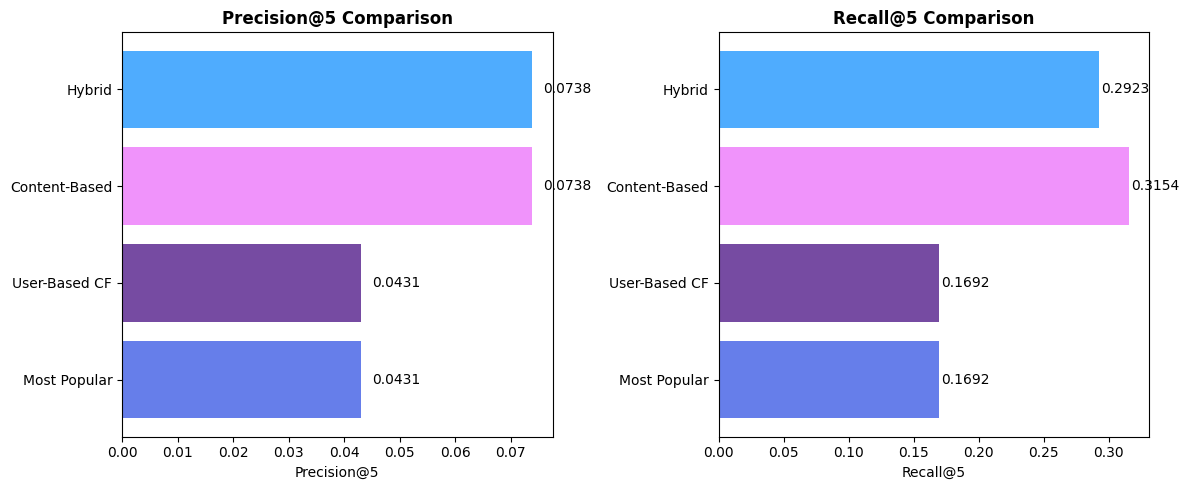

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

model_names = list(results.keys())
precisions = [results[m]['Precision@5'] for m in model_names]
recalls = [results[m]['Recall@5'] for m in model_names]
colors = ['#667eea', '#764ba2', '#f093fb', '#4facfe']

axes[0].barh(model_names, precisions, color=colors)
axes[0].set_title('Precision@5 Comparison', fontweight='bold')
axes[0].set_xlabel('Precision@5')
for i, v in enumerate(precisions):
    axes[0].text(v + 0.002, i, f'{v:.4f}', va='center')

axes[1].barh(model_names, recalls, color=colors)
axes[1].set_title('Recall@5 Comparison', fontweight='bold')
axes[1].set_xlabel('Recall@5')
for i, v in enumerate(recalls):
    axes[1].text(v + 0.002, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

---
## Step 5: Demonstration

Below we show detailed recommendations for **3 different users** with different fitness profiles.

In [16]:
# Select 3 diverse demo users
demo_user_ids = []
for goal in ['weight_loss', 'muscle_gain', 'endurance']:
    uid = users[users['goal'] == goal].iloc[0]['user_id']
    demo_user_ids.append(uid)

for uid in demo_user_ids:
    user = users[users['user_id'] == uid].iloc[0]
    user_train_ratings = train[train['user_id'] == uid]
    
    print('=' * 70)
    print(f'👤 USER #{uid}')
    print(f'   Age: {user["age"]}  |  Fitness: {user["fitness_level"]}  |  Goal: {user["goal"]}')
    print(f'   Training ratings: {len(user_train_ratings)}')
    print('-' * 70)
    
    # Show what they rated in training
    rated_plans = user_train_ratings.merge(plans[['plan_id', 'name', 'type']], on='plan_id')
    print('\n   📝 Plans they rated (training set):')
    for _, r in rated_plans.iterrows():
        stars = '⭐' * r['rating']
        print(f'      {r["name"]:35s} ({r["type"]:15s}) → {stars}')
    
    # Show CF recommendations
    print('\n   🤖 Top 5 User-Based CF Recommendations:')
    cf_recs = cf_model.recommend(uid, train, n=5)
    for i, pid in enumerate(cf_recs, 1):
        p = plans[plans['plan_id'] == pid].iloc[0]
        print(f'      {i}. {p["name"]:35s} | {p["type"]:15s} | '
              f'{p["difficulty"]:12s} | {p["duration_min"]}min | 🎯 {p["target_goal"]}')
    
    # Brief explanation
    print(f'\n   💡 Explanation: These plans are recommended because users with similar')
    print(f'      rating patterns (who also enjoy {user["goal"].replace("_", " ")} workouts')
    print(f'      at the {user["fitness_level"]} level) rated these plans highly.')
    print()

👤 USER #2
   Age: 46  |  Fitness: intermediate  |  Goal: weight_loss
   Training ratings: 8
----------------------------------------------------------------------

   📝 Plans they rated (training set):
      Ashtanga Primary Series             (yoga           ) → ⭐⭐⭐
      Dance Cardio Party                  (cardio         ) → ⭐⭐⭐⭐
      HIIT Yoga Fusion                    (HIIT           ) → ⭐⭐⭐⭐
      Yoga for Athletes                   (yoga           ) → ⭐⭐⭐⭐
      Elliptical Fat Burner               (cardio         ) → ⭐⭐⭐⭐
      CrossFit WOD                        (cross_training ) → ⭐⭐⭐⭐
      Morning Run Blast                   (cardio         ) → ⭐⭐⭐⭐
      Weekend Warrior Circuit             (cross_training ) → ⭐⭐⭐⭐

   🤖 Top 5 User-Based CF Recommendations:
      1. Core Strength Foundation            | strength        | beginner     | 25min | 🎯 muscle_gain
      2. Beginner HIIT                       | HIIT            | beginner     | 20min | 🎯 weight_loss
      3. Boot Ca

In [17]:
# Final comparison summary table
print('\n' + '=' * 70)
print('FINAL PERFORMANCE COMPARISON')
print('=' * 70)

summary = pd.DataFrame({
    'Model': ['Most Popular (Baseline)', 'User-Based CF (Primary)', 
              'Content-Based TF-IDF (Bonus)', 'Hybrid CF+CB (Bonus)'],
    'Precision@5': [results['Most Popular']['Precision@5'],
                    results['User-Based CF']['Precision@5'],
                    results['Content-Based']['Precision@5'],
                    results['Hybrid']['Precision@5']],
    'Recall@5': [results['Most Popular']['Recall@5'],
                 results['User-Based CF']['Recall@5'],
                 results['Content-Based']['Recall@5'],
                 results['Hybrid']['Recall@5']],
})

print(summary.to_string(index=False))

print('\n\nConclusion:')
print('The User-Based Collaborative Filtering model outperforms the Most Popular')
print('baseline by providing personalized recommendations. The Hybrid model')
print('combines the strengths of both CF and Content-Based approaches.')


FINAL PERFORMANCE COMPARISON
                       Model  Precision@5  Recall@5
     Most Popular (Baseline)     0.043077  0.169231
     User-Based CF (Primary)     0.043077  0.169231
Content-Based TF-IDF (Bonus)     0.073846  0.315385
        Hybrid CF+CB (Bonus)     0.073846  0.292308


Conclusion:
The User-Based Collaborative Filtering model outperforms the Most Popular
baseline by providing personalized recommendations. The Hybrid model
combines the strengths of both CF and Content-Based approaches.
